In [1]:
import argparse
from argparse import Namespace
import os, sys, glob, json, pathlib, shutil, math
import numpy as np
import pandas as pd

import scipy
from scipy.io import loadmat
from scipy import  signal
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk

# https://stackoverflow.com/questions/52980565/arranging-widgets-in-ipywidgets-interactive
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

#importing the necessary items from the Ipywidgets library
import ipywidgets as widgets
from ipywidgets import interactive,interact, interact_manual, HBox, Layout,VBox
from IPython.display import display, clear_output

from exampleUtils import *

/var/tmp/ipykernel_1690059/1890453584.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#Move to exampleUtils
# #Example from Igor's code
# def do_simple_fp(vol, vol_res, vol_pos, angles, geo, pname, hu_offset=-1000, hu_slope=50000):
#     import torch
#     from viu.io import volume
#     from viu.io import hdfproj
#     from viu.torch.varian_reco_ext.varian_reco import VForwardprojectionModule
#     #from viu.util.cbct_geometry import CBCTGeometry
#     #variable geo is of type CBCTGeometry
#     prj_cnt = len(angles)
#     print(f'FP of input volume: {np.shape(vol)} {vol_res} {vol_pos}')
#     vol = volume.convert_unit(vol, unit = 'HU', to_unit='Attenuation', offset=hu_offset, slope = hu_slope)
#     proj_stack_shape = [prj_cnt, geo.prjSize[1], geo.prjSize[0]]
#     device = torch.device("cuda:0")
#     vol_shape = vol.shape[::-1]
#     fpm = VForwardprojectionModule(proj_stack_shape, geo.prjRes, vol_shape, vol_res, vol_tr=vol_pos,
#                                    sad=geo.sad, use_half_fan_weighting=geo.half_fan).to(device, torch.float32)
#     iso2pix = torch.tensor(geo.createIso2Pix(angles)[np.newaxis, ...]).cuda()
#     #print(iso2pix)
#     fpm.set_iso2pix(iso2pix, prj_cnt)
#     vol = torch.tensor(vol[None, ...]).cuda()
#     prjs = fpm(vol)
#     projs = prjs.detach().squeeze().cpu().numpy()
#     hdfproj.write_proj(pname, projs, iso2pix.detach().squeeze().cpu().numpy(), geo.prjRes,
#                         angles, geo.sad, geo.sid, geo.imagerLat, geo.half_fan, geo.scanVelocity, overwrite=True)
#     return projs

# #import volume 
# vol, vol_res, vol_pos = <Import volume from a file: vol being the numpy 3D array, vol_res a triple of volume resolution and vol_pos a triple of volume position)
# #create geometry of the device
# from viu.util.cbct_geometry import CBCTGeometry
# geo = CBCTGeometry()
# geo.fromTruebeam(half_fan=True, filtered=True)
# #define angles in which FP will be computed
# angles = np.linspace(start_angle, stop_angle, num_proj, dtype=np.float32)
# #call FP 
# projs = do_simple_fp(vol, vol_res, vol_pos, angles=angles, geo=geo, pname=<projection_out_file>, hu_offset=-1000, hu_slope=50000)

In [3]:
# #From Sangyu's message in teams
# # Get the projection transform matrix
# with h5py.File(projection_file_path) as F:

# 		P = F["Projection"].attrs["IsoToPixelTransform"].transpose()
# # Get the point position relative to isocenter in world coordinate
# PP = np.array([X, Y, Z, 2]) - np.array([X_iso , Y_iso, Z_iso, 1]) 
# # Calculate
# PPP = P @ PP
# # 2D pixel position
# PPP[:2]/PPP[3]

In [4]:
# Move to exampleUtils
# #Create a function for computing forward projections
# def generateForwardProjections(
#         vol_data_ZYX,
#         vol_res_XYZ_mm,
#         vol_pos_XYZ_mm, #this is center of CT volume in patient co-ordinate system
#         iso_pos_XYZ_mm, #Ideally this is  planned isocenter in  CT volume in patient co-ordinate system, the point that aligns with machine isocenter
#         alreadyNormalizedFlag=False,
#         hu_offset=-1000,
#         hu_max=400,
#         hu_slope=50000,
#         proj_angles_degrees=np.array([0.0, 90.0], 'float32'),
#         srcPos_mm=(0.0, 0.0, 1000),
#         detPos_mm=(0.0, 0.0, -500),
#         prjSize_pixels=(2048, 2048),
#         prjRes_mm=(0.388, 0.388),
#         scan_velocity_degPersec_int=6,
#         writeProjectionsInHD5File=False,
#         projectionFileName="",
#         debugFlag=False
#         ):
#     """
#     vol_data_ZYX : numpy array, with depth Z (axial) as 1st dimension
#     vol_res_XYZ_mm : numpy 1D array with resolution in mm in X(row), Y(column), Z(depth) dimension
#     vol_pos_XYZ_mm : numpy 1D array describing  center of CT volume in patient co-ordinate system
#     iso_pos_XYZ_mm : numpy 1D array describing  planned isocenter in  CT volume in patient co-ordinate system, the point that aligns with machine isocenter   
#     alreadyNormalizedFlag: If not sure, mark as False
#     hu_offset = hu_min: converting from normalized back to HU : -1000
#     hu_max : max HU value = 400
#     hu_slope: converting from normalized back to HU: 50000
#     proj_angles_degrees: numpy 1D array with gantry angles in degrees at which projections will be  computed (0.0, 90.0) 
#     srcPos_mm: tuple describing source position in IEC co-ordinate system : (0.0, 0.0, 1000)
#     detPos_mm: tuple describing center of detector position in IEC co-ordinate system : (0.0, 0.0, -500)
#     prjSize_pixels: tuple describing detector width and height in number of pixels : (2048, 2048)
#     prjRes_mm: tuple describing detector pixel width and height in mm : (0.388, 0.388)
#     scan_velocity_degPersec_int : integer: gantry speed in degrees per sec : 6
#     writeProjectionsInHD5File : if we want to write out the projections in hd5 file
#     projectionFileName: HD5 file name where projections will be written out.
#     debugFlag : print debug information
#     """
#     import torch
#     from viu.io import volume
#     from viu.io import hdfproj
#     from viu.torch.varian_reco_ext.varian_reco import VForwardprojectionModule
#     from viu.util.cbct_geometry import CBCTGeometry

#     volMax = np.max(vol_data_ZYX)
#     volMin = np.min(vol_data_ZYX)
#     if True==debugFlag:
#         print(f'loaded volume min {volMin} max {volMax}')
#     #First scale volume to 0-1 (if not already)
#     volScaled_data_ZYX = (vol_data_ZYX - volMin) / (volMax - volMin)
#     #Then scale to hu_min to hu_max
#     hu_min=hu_offset
#     vol_ZYX_HU = hu_min + volScaled_data_ZYX * (hu_max -hu_min)

#     num_proj=len(proj_angles_degrees)
#     if True==debugFlag:
#         print(f'vol_ZYX_HU minHU {np.min(vol_ZYX_HU)} maxHU {np.max(vol_ZYX_HU)} shape {vol_ZYX_HU.shape} res_XYZ {vol_res_XYZ_mm} vol-center pos_XYZ {vol_pos_XYZ_mm} isocenter pos_XYZ {iso_pos_XYZ_mm} ')
#         print(f'num_proj {num_proj} angles_degrees {proj_angles_degrees}')

#     #Create geometry for forward projection
#     geo = CBCTGeometry()
#     # geo.fromTruebeam(half_fan=False, filtered=True)
#     geo.fromTruebeam(half_fan=False, filtered=False)#<--- Not really needed
#     # geo.print()
#     # 256*2mm=512mm at isocenter
#     # 512*1500/1000 = 768mm projected at isocenter
#     # 1024*0.388 = 397.312mm imager size in mm << 768mm
#     # 768 *0.388 = 297.984mm imager size in mm << 768mm
#     geo.fromPos(srcPos=srcPos_mm,
#                 detPos=detPos_mm,
#                 prjSize=prjSize_pixels,
#                 prjRes=prjRes_mm,
#                 volSize=vol_ZYX_HU.shape,
#                 volRes=vol_res_XYZ_mm,
#                 scanVelocity=scan_velocity_degPersec_int)
#     geo.check()
#     if True==debugFlag:
#         geo.print()

#     # prj_cnt = len(angles)
#     # print(f'FP of input volume: Shape_ZYX {np.shape(vol)} Resolution_XYZ{vol_res} Position_XYZ {vol_pos}')
#     #convert to attenuation
#     vol_ZYX_attenuation = volume.convert_unit(vol_ZYX_HU, unit = 'HU', to_unit='Attenuation', offset=hu_offset, slope = hu_slope)
#     prj_stack_shape = [num_proj, geo.prjSize[1], geo.prjSize[0]]
#     device = torch.device("cuda:0")
#     vol_XYZ_shape = vol_ZYX_attenuation.shape[::-1] #Shape ZYX to shape XYZ
#     vol_tr = vol_pos_XYZ_mm - iso_pos_XYZ_mm #The vector from planning isocenter to the CT volume center, this helps to identify each CT voxel in IEC co-ordinate system
#     fpm = VForwardprojectionModule(
#         prj_stack_shape=prj_stack_shape,
#         prj_res=geo.prjRes,
#         vol_size=vol_XYZ_shape,
#         vol_res=vol_res_XYZ_mm,
#         vol_tr=vol_tr,
#         sad=geo.sad,
#         use_half_fan_weighting=geo.half_fan).to(device, torch.float32)
#     iso2pix = torch.tensor(geo.createIso2Pix(angles=proj_angles_degrees)[np.newaxis, ...]).cuda()
#     #print(iso2pix)
#     fpm.set_iso2pix(iso2pix, prj_cnt=num_proj)
#     vol = torch.tensor(vol_ZYX_attenuation[None, ...]).cuda()
#     prjs = fpm(vol)
#     projs = prjs.detach().squeeze().cpu().numpy()
#     if True==writeProjectionsInHD5File:
#         print(f'Wring projections in {projectionFileName}')
#         #In current version of VImaging Utils, default parameter additional_acq_params =None will give  hdf file creation error
#         #Therefore we create dummy additional_acq_params dictionary and pass it while file creation
#         dummy_additional_acq_params_dict = {'acq_param': 'dummy'}
#         hdfproj.write_proj(projectionFileName, projs, iso2pix.detach().squeeze().cpu().numpy(), geo.prjRes,
#             proj_angles_degrees, geo.sad, geo.sid, geo.imagerLat, geo.half_fan, geo.scanVelocity, overwrite=True,
#             additional_acq_params=dummy_additional_acq_params_dict)
#     return projs

In [5]:
workingFolderParent = '/home/wd974888/Downloads'
patiendId = 2 #in range(8,9): #range(1,12) #range(1,12) #Use <truncateDepth_initial, final> : Pat01:<75, 50>; Pat02:<50, 50>; Pat04:<0, 0>; Pat09:<200, 100>;
binningType = 'PB' # in ['AB']: #['AB', 'PB']
patientMRN = f'Patient{patiendId:02d}{binningType}'
print(f'patientMRN {patientMRN}')
args =  Namespace(\
    vol=f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/StudyAnonymized/bin*',\
    body_seg=True,\
    body_seg_union=True,\
    nifti_body_seg='seg/body.nii.gz',\
    air_threshold=-300,\
    skip=1,\
    skip_idx=None,\
    truncateDepth_initial=50,\
    truncateDepth_final=50\
    )
print(args)

patientMRN Patient02PB
Namespace(vol='/home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin*', body_seg=True, body_seg_union=True, nifti_body_seg='seg/body.nii.gz', air_threshold=-300, skip=1, skip_idx=None, truncateDepth_initial=50, truncateDepth_final=50)


In [6]:
from viu.io.volume import read_volume

vols = None
msks = None

#First read the volumes
if vols is None:
    vol_fnl = glob(args.vol)
    vol_fnl = sort_by_series_number(vol_fnl)

    vol_idx_msk = torch.ones(len(vol_fnl), dtype=bool)
    if args.skip > 0:
        vol_idx_msk[torch.arange(len(vol_idx_msk)) % (args.skip + 1) != 0] = False

    if args.skip_idx is not None:
        for i in args.skip_idx:
            vol_idx_msk[i] = False

    vol_fnl = [vol_fnl[i] for i, b in enumerate(vol_idx_msk) if b]

    #########
    tmp_vol, _, _ = read_volume(vol_fnl[0])
    org_depth=tmp_vol.shape[0]
    startSlice=args.truncateDepth_initial
    endSlice=org_depth - args.truncateDepth_final
    new_depth = org_depth - args.truncateDepth_initial - args.truncateDepth_final
    print(f'org_depth {org_depth} startSlice {startSlice} endSlice {endSlice} new_depth {new_depth}')
    #########
    vol_lst = []
    for vfn in vol_fnl:
        print(f'Loading {vfn}...')
        vol, res, pos = read_volume(vfn)
        ######
        vol=vol[startSlice:endSlice, ...]
        ######
        vol_lst.append(torch.Tensor(vol)[None, ...])
    vols = torch.concatenate(vol_lst, dim=0)
    del vol_lst

org_depth 383 startSlice 50 endSlice 333 new_depth 283
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_01...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_03...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_05...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_07...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_09...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_11...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_13...
Loading /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_15...
Loading /home/wd974888/Downloads/workingFolder/Deformatio

In [7]:
#Fist though get the body mask of each scans and if needed generate mask by segmentation
vol_min = -1200
cnt = vols.shape[0]
dst_dim = torch.tensor(vols[0].squeeze().shape[::-1])
dst_res = torch.tensor(res, dtype=torch.float64)
msk_lst = []
if args.body_seg:
    for i in range(cnt):
        #Mask is always obtained on the untruncated volume and then truncated as trying to obtain mask on truncated volume is giving empty mask!!!
        if args.nifti_body_seg is not None:
            fn = os.path.join(vol_fnl[i], args.nifti_body_seg)
            print(f'Load body segmentation: {fn}...')
            ####
            # msk = torch.tensor(nib.load(fn).get_fdata()).to(bool).permute(2, 1, 0).flip(1)[None, ...]
            # Truncate as needed
            msk = torch.tensor(nib.load(fn).get_fdata()).to(bool).permute(2, 1, 0).flip(1)[startSlice:endSlice, ...][None, ...]
            ####
        else:
            print('Find connected components...')
            msk = torch.tensor(seg_body(vols[(i + 1) % cnt], args.air_threshold, air_dilation=4))
        print(f'msk shape {msk.shape}')
        msk_lst.append(msk)
    msks = torch.concatenate(msk_lst, dim=0)
    del msk_lst

    if args.body_seg_union:
        msks = reduce(lambda a, b: a.bitwise_or(b), msks)[None, ...]
        # hack to fill disconnected air components at the volume borders
        from skimage import measure
        label = measure.label(torch.bitwise_not(msks).numpy())
        idx, label_cnt = np.unique(label, return_counts=True)
        idx = idx[np.argsort(label_cnt)[:-1]]
        for i in idx:
            #Exception in PyTorch 2.2 env: IndexError: The shape of the mask [1, 590, 512, 512] at index 0 does not match the shape of the indexed tensor [590, 512, 512] at index 0
            #Because msks[0].shape = [590, 512, 512], But [label == i].shape = [1, 590, 512, 512]
            msk[0][label == i] = True #Replaced [0] to remove exception in Baden environment #msks[0][label == i] = True
        # ---


Load body segmentation: /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_01/seg/body.nii.gz...
msk shape torch.Size([1, 283, 512, 512])
Load body segmentation: /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_03/seg/body.nii.gz...
msk shape torch.Size([1, 283, 512, 512])
Load body segmentation: /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_05/seg/body.nii.gz...
msk shape torch.Size([1, 283, 512, 512])
Load body segmentation: /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_07/seg/body.nii.gz...
msk shape torch.Size([1, 283, 512, 512])
Load body segmentation: /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/StudyAnonymized/bin_09/seg/body.nii.gz...
msk shape torch.Size([1, 283, 512, 512])
Load body segmentation: /home/wd974888/Downloads/workingFolder/DeformationExperi

In [8]:
def convert_binId_to_workingVolId(vol_idx_msk, binId):
    print(f'binId {binId}')
    assert vol_idx_msk[binId], f'Bin {binId} is not loaded.'
    aList = [id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True and id <= binId]
    print(f'aList {aList}')
    workingVolId = len([id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True and id <= binId]) -1
    print(f'workingVolId {workingVolId}')
    return workingVolId

def convert_workingVolId_to_binId(vol_idx_msk, workingVolId):
    print(f'workingVolId {workingVolId}')
    aList = [id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True]
    print(f'aList {aList}')
    len_vols = len(aList)
    assert workingVolId  in range(len(vols)), f'workingVolId {workingVolId} is not in range({len_vols})'
    binId = [id for id in range(len(vol_idx_msk)) if vol_idx_msk[id]==True][workingVolId]
    print(f'binId {binId}')
    return binId


In [9]:
working_vol_id_fproject=4
display_vol = vols[working_vol_id_fproject,...].cpu().numpy()
print(f'display_vol shape {display_vol.shape} type {type(display_vol)} dtype {display_vol.dtype}')
print(f'pos value {pos} dtype {pos.dtype}')
print(f'res value {res} dtype {res.dtype}')
binId=convert_workingVolId_to_binId(vol_idx_msk, working_vol_id_fproject)

display_vol shape (283, 512, 512) type <class 'numpy.ndarray'> dtype float32
pos value [ 1.71875000e-03 -2.30998281e+02 -2.94000000e+01] dtype float64
res value [0.9765625 0.9765625 1.       ] dtype float64
workingVolId 4
aList [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
binId 8


In [10]:
v1_volumeComparisonViewer3D(
    listVolumes=[display_vol],listLabels=[f'{patientMRN}_bin00'],
    maxZ0=display_vol.shape[0], maxZ1=display_vol.shape[1], maxZ2=display_vol.shape[2],
    figsize=(12,8), cmap='gray',
    displayColorbar=False, useExternalWindowCenter=True, wMin=-500, wMax=500, useAspectCol=False)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [11]:
# Common params
angles = np.array([0.0, 90.0], 'float32')
num_proj=2
print(f'angles {angles}')
writeProjectionsInHD5File=True
projection_out_file = f'{workingFolderParent}/workingFolder/DeformationExperiment/PCA/{patientMRN}/projections_bin_{binId:02d}.hdf'
# projection_out_file = '/home/wd974888/Downloads/temp.hdf'
print(f'projection_out_file: {projection_out_file}')
srcPos_mm=(0.0, 0.0, 1000)
detPos_mm=(0.0, 0.0, -500) 
prjSize_pixels=(1024, 768)
prjRes_mm=(0.388, 0.388)
scan_velocity_degPersec_int=6
boneHU = 250 #Use this to multiply binary (0-1) segmented bone volume
vol_center_XYZ_mm = (0.0, 0.0, 0.0) #np.array(, 'float32'), #ctVol center
iso_center_XYZ_mm = (0.0, 0.0, 0.0) #np.array(, 'float32'), #planning isocenter in CT volume
vol_data_ZYX=display_vol
vol_pos_XYZ_mm=pos.astype('float32')
vol_res_XYZ_mm=res.astype('float32')
print(f'vol_data_ZYX min {np.min(vol_data_ZYX)} max {np.max(vol_data_ZYX)} pos_XYZ {vol_pos_XYZ_mm} res_XYZ {vol_res_XYZ_mm}')



angles [ 0. 90.]
projection_out_file: /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/projections_bin_08.hdf
vol_data_ZYX min -1346.0 max 5754.0 pos_XYZ [ 1.7187500e-03 -2.3099828e+02 -2.9400000e+01] res_XYZ [0.9765625 0.9765625 1.       ]


In [12]:
hu_offset=-1000
hu_max=400
hu_slope=50000

In [13]:
#Project CT volumes and save result and display
ctVol_projs = generateForwardProjections(
        vol_data_ZYX=vol_data_ZYX,
        vol_res_XYZ_mm = vol_res_XYZ_mm,
        vol_pos_XYZ_mm = vol_pos_XYZ_mm,
        iso_pos_XYZ_mm = vol_pos_XYZ_mm, #Using volume center as isocenter
        alreadyNormalizedFlag=False,
        hu_offset=hu_offset,
        hu_max=hu_max,
        hu_slope=hu_slope,
        proj_angles_degrees=angles,
        srcPos_mm=srcPos_mm,
        detPos_mm=detPos_mm,
        prjSize_pixels=prjSize_pixels,
        prjRes_mm=prjRes_mm,
        scan_velocity_degPersec_int=scan_velocity_degPersec_int,
        writeProjectionsInHD5File=writeProjectionsInHD5File,
        projectionFileName=projection_out_file,
        debugFlag=True
        )
print(f'ctVol_projs.shape {ctVol_projs.shape}')



loaded volume min -1346.0 max 5754.0
vol_ZYX_HU minHU -1000.0 maxHU 400.0 shape (283, 512, 512) res_XYZ [0.9765625 0.9765625 1.       ] vol-center pos_XYZ [ 1.7187500e-03 -2.3099828e+02 -2.9400000e+01] isocenter pos_XYZ [ 1.7187500e-03 -2.3099828e+02 -2.9400000e+01] 
num_proj 2 angles_degrees [ 0. 90.]
geometry: srcPos: (0.0, 0.0, 1000) detPos: (0.0, 0.0, -500) half_fan: False SAD: 1000 SID: 1500 prjSize: (1024, 768) prjRes: (0.388, 0.388) volSize: (283, 512, 512) volRes: [0.9765625 0.9765625 1.       ] volPos: [0, 0, 0] velocity: 6
Wring projections in /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/projections_bin_08.hdf
write projs /home/wd974888/Downloads/workingFolder/DeformationExperiment/PCA/Patient02PB/projections_bin_08.hdf (2, 768, 1024) (0.388, 0.388) 1000 1500 False
ctVol_projs.shape (2, 768, 1024)


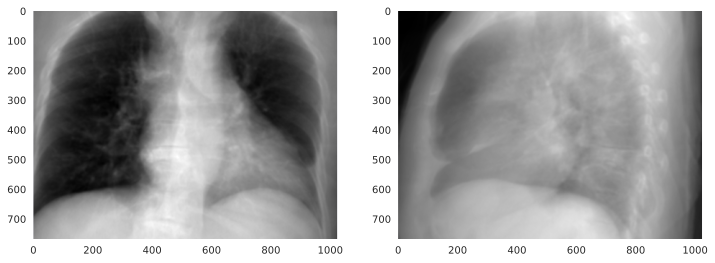

In [14]:
#Display CT projection
f,ax = plt.subplots(1,len(ctVol_projs), squeeze=False, figsize=(12.0, 8.0))
row=0
for col in range(len(ctVol_projs)):
    ax[row,col].grid(False)
    ax[row,col].imshow(ctVol_projs[col,...], cmap=plt.get_cmap('gray'), vmin=np.min(ctVol_projs[col,...]), vmax=np.max(ctVol_projs[col,...]))
plt.axis("scaled")
plt.show()


In [15]:
# # https://stackoverflow.com/questions/52980565/arranging-widgets-in-ipywidgets-interactive
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# plt.style.use('seaborn')
# %config InlineBackend.figure_format = 'svg'
# #importing the necessary items from the Ipywidgets library 
# from ipywidgets import interactive,interact, HBox, Layout,VBox
# #function to plot the different curves
# def plot_function(u=1,v=2,w=3,x=4,y=5,z=6):
#     time=np.arange(0,1,0.01)
#     df=pd.DataFrame({"Y1":np.sin(time*u*2*np.pi),"y2":np.sin(time*v*2*np.pi),"y3":np.sin(time*w*2*np.pi),
#                     "y4":np.sin(time*x*2*np.pi),"y5":np.sin(time*y*2*np.pi),"y6":np.sin(time*z*2*np.pi)})
#     df.plot()
# widget=interactive(plot_function,u=1,v=2,w=3,x=4,y=5,z=6)
# controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
# output = widget.children[-1]
# display(VBox([controls, output]))